## Experimente Solutie 

In [1]:
from PIL import Image
import numpy as np

def image_to_pixel_features(image_path):

    # Load the image
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    pixels = np.array(image)

    # Prepare the data
    samples = []

    for y in range(height):
        for x in range(width):
            r, g, b = pixels[y, x]
            samples.append([x, y, r, g, b])

    # Convert to NumPy array if needed
    samples = np.array(samples)
    return samples, width, height

In [2]:
pixels, width, height = image_to_pixel_features("../../images2/image_00000.png")

Estimated number of objects: 8


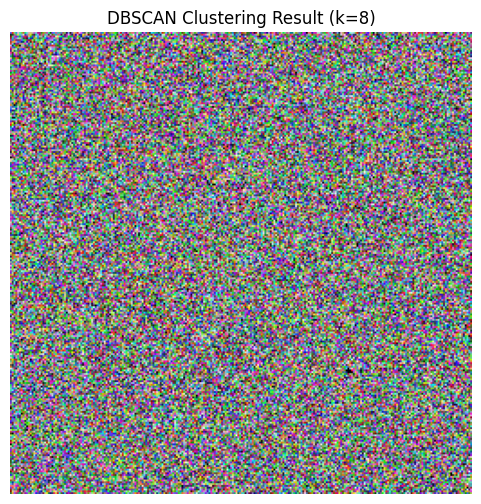

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

def dbscan_image_segmentation(pixels, height, width, eps=0.5, min_samples=5, show_plot=False):
    """
    Applies DBSCAN clustering to an image's pixel data.

    Args:
        pixels (np.ndarray): Flattened array of image pixels (shape: height*width x features).
        height (int): Height of the original image.
        width (int): Width of the original image.
        eps (float): DBSCAN epsilon parameter (neighborhood radius).
        min_samples (int): DBSCAN minimum number of samples for a core point.
        show_plot (bool): Whether to plot the result.

    Returns:
        Tuple[np.ndarray, np.ndarray, int]:
            - labels: Array of cluster labels for each pixel.
            - clustered_img: Image with color-coded clusters.
            - n_clusters: Number of clusters found (excluding noise).
    """

    # Scale features
    X_scaled = StandardScaler().fit_transform(pixels)

    # Apply DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
    labels = db.labels_

    # Count clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Estimated number of objects: {n_clusters}")

    # Assign each label a random color (noise = black)
    label_colors = np.array([
        [np.random.randint(0, 255) for _ in range(3)] if label != -1 else [0, 0, 0]
        for label in labels
    ])

    clustered_img = label_colors.reshape((height, width, 3)).astype(np.uint8)

    # Optional visualization
    if show_plot:
        plt.figure(figsize=(6, 6))
        plt.imshow(clustered_img)
        plt.title(f"DBSCAN Clustering Result (k={n_clusters})")
        plt.axis('off')
        plt.show()

    return labels, clustered_img, n_clusters

pixels, width, height = image_to_pixel_features("../../images2/image_00000.png")

labels, clustered_image, num_clusters = dbscan_image_segmentation(
    pixels, height, width, eps=0.5, min_samples=5, show_plot=True
)

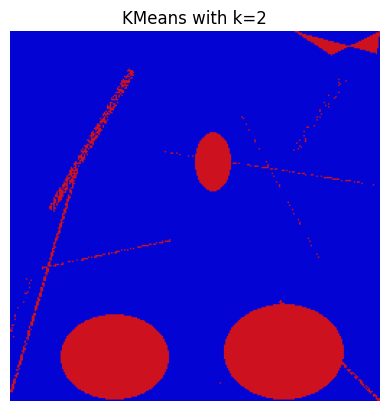

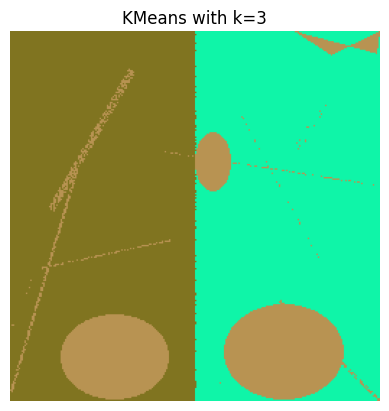

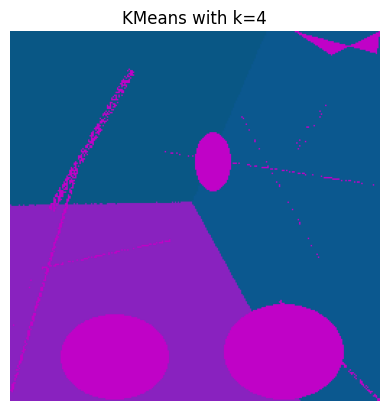

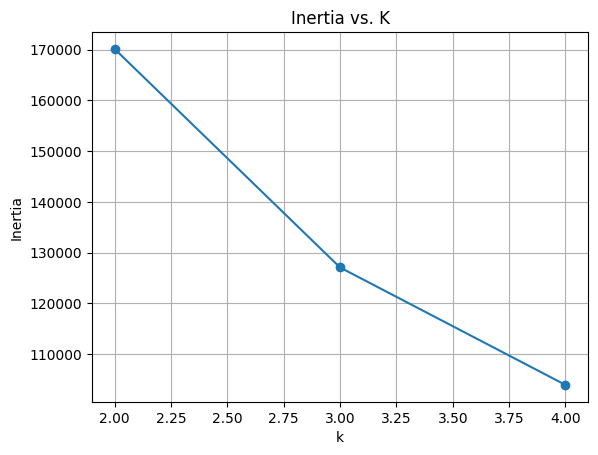

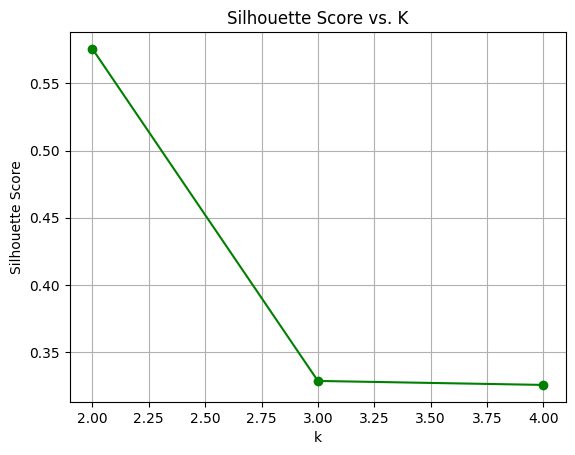

Best K based on silhouette score: 2


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def kmeans_image_segmentation(pixels, height, width, k_range=(2, 5), show_plots=False, binarize=False):
    """
    Applies KMeans clustering to image pixels, evaluates multiple k values.

    Args:
        pixels (np.ndarray): Image pixels flattened (e.g., shape (H*W, 3) or with added coordinates).
        height (int): Image height.
        width (int): Image width.
        k_range (tuple): Range of k values to try, e.g., (2, 5) means k = 2, 3, 4.
        show_plots (bool): Whether to show cluster images and metric plots.

    Returns:
        dict: Dictionary containing:
            - 'inertias': List of inertia values.
            - 'silhouette_scores': List of silhouette scores.
            - 'clustered_images': List of clustered images for each k.
            - 'best_k': k with the highest silhouette score.
    """

    X_scaled = StandardScaler().fit_transform(pixels)

    inertias = []
    sil_scores = []
    clustered_images = []
    k_values = list(range(k_range[0], k_range[1]))

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_scaled)

        inertia = kmeans.inertia_
        sil = silhouette_score(X_scaled, labels)

        inertias.append(inertia)
        sil_scores.append(sil)

        # print(f"k={k} | Inertia={inertia:.2f} | Silhouette={sil:.3f}")
        if binarize:
            unique, counts = np.unique(labels, return_counts=True)
            cluster_sizes = dict(zip(unique, counts))

            # Find the cluster with the most pixels
            max_cluster_label = max(cluster_sizes, key=cluster_sizes.get)

            # Create binary image: black for largest cluster, white for all others
            binary_pixels = np.where(
                labels.reshape((height, width)) == max_cluster_label,
                0,    # Black
                255   # White
            ).astype(np.uint8)

            # Convert to 3-channel RGB
            clustered_pixels = np.stack([binary_pixels]*3, axis=-1)

            clustered_images.append(clustered_pixels)

        else:
            # Assign random color to each cluster
            cluster_colors = np.array([
                [np.random.randint(0, 256) for _ in range(3)]
                for _ in range(k)
            ])
            clustered_pixels = cluster_colors[labels].reshape((height, width, 3)).astype(np.uint8)
            clustered_images.append(clustered_pixels)

        if show_plots:
            plt.figure()
            plt.imshow(clustered_pixels)
            plt.title(f"KMeans with k={k}")
            plt.axis('off')

    if show_plots:
        plt.figure()
        plt.plot(k_values, inertias, marker='o')
        plt.title("Inertia vs. K")
        plt.xlabel("k")
        plt.ylabel("Inertia")
        plt.grid()

        plt.figure()
        plt.plot(k_values, sil_scores, marker='o', color='green')
        plt.title("Silhouette Score vs. K")
        plt.xlabel("k")
        plt.ylabel("Silhouette Score")
        plt.grid()

        plt.show()

    best_k_index = int(np.argmax(sil_scores))
    best_k = k_values[best_k_index]

    return {
        "inertias": inertias,
        "silhouette_scores": sil_scores,
        "clustered_images": clustered_images,
        "best_k": best_k
    }

pixels, width, height = image_to_pixel_features("../../images2/image_00000.png")
result = kmeans_image_segmentation(
    pixels, height, width, k_range=(2, 5), show_plots=True
)

print("Best K based on silhouette score:", result["best_k"])

## Another KMeans Attempt

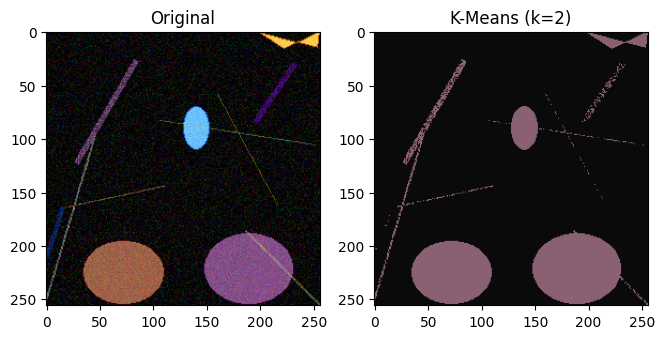

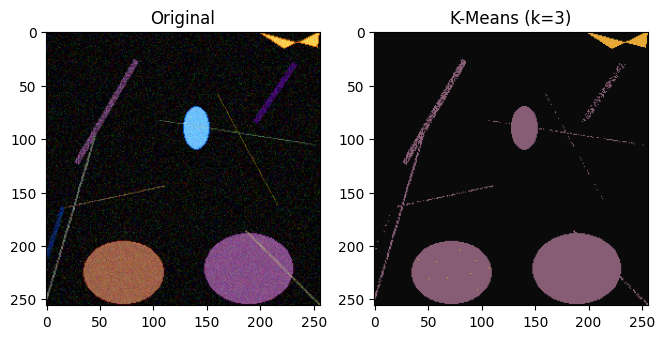

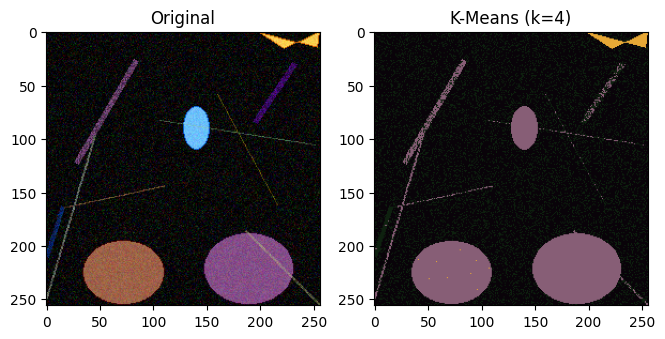

In [5]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

image = cv2.imread("../../images2/image_00000.png")
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_flat = img_rgb.reshape((-1, 3))

for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(img_flat)
    segmented = kmeans.cluster_centers_[kmeans.labels_].reshape(image.shape).astype(np.uint8)
    
    # Show results
    plt.figure(figsize=(12,6))
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title("Original")

    plt.subplot(1, 3, 2)
    plt.imshow(segmented)
    plt.title(f"K-Means (k={k})")

## Celular Automata

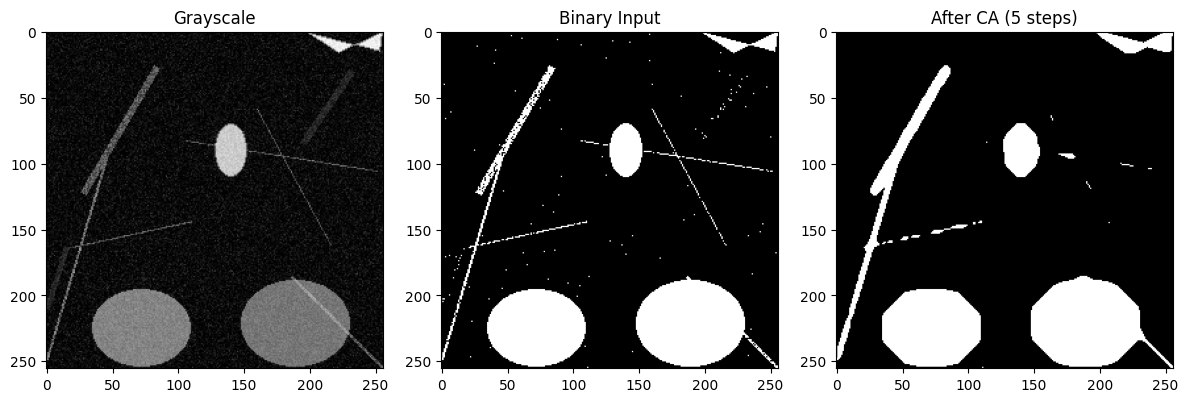

In [6]:
import cv2

def cellular_automata_segmentation(image_path, steps=5, threshold=50, show_plots=False):
    """
    Applies cellular automata to a grayscale image for segmentation / denoising.

    Args:
        image_path (str): Path to the input image.
        steps (int): Number of cellular automata iterations.
        threshold (int): Threshold for binarizing grayscale image.
        show_plots (bool): If True, show matplotlib plots.

    Returns:
        Tuple[np.ndarray, np.ndarray]: (binary before CA, binary after CA)
    """

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Binary threshold
    _, binary = cv2.threshold(gray, threshold, 1, cv2.THRESH_BINARY)

    def apply_ca_step(binary_img):
        new_img = binary_img.copy()
        height, width = binary_img.shape
        for y in range(1, height - 1):
            for x in range(1, width - 1):
                neighborhood = binary_img[y - 1:y + 2, x - 1:x + 2]
                count = np.sum(neighborhood) - binary_img[y, x]

                if binary_img[y, x] == 1:
                    if count < 2:
                        new_img[y, x] = 0
                else:
                    if count >= 4:
                        new_img[y, x] = 1
        return new_img

    # Apply CA for `steps` iterations
    ca_result = binary.copy()
    for _ in range(steps):
        ca_result = apply_ca_step(ca_result)

    if show_plots:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale")

        plt.subplot(1, 3, 2)
        plt.imshow(binary, cmap='gray')
        plt.title("Binary Input")

        plt.subplot(1, 3, 3)
        plt.imshow(ca_result, cmap='gray')
        plt.title(f"After CA ({steps} steps)")
        plt.tight_layout()
        plt.show()

    return binary, ca_result

binary, ca_output = cellular_automata_segmentation(
    "../../images2/image_00000.png",
    steps=5,
    show_plots=True
)

## Complete Solution

In [10]:
import os
from os import listdir
from os.path import isfile, join

def complete_solution(PATH = "../../images2/", save_dir='predictions/', algorithm='KMeans', show_plots=False):

    os.makedirs(save_dir, exist_ok=True)
    onlyfiles = [f for f in listdir(PATH) if isfile(join(PATH, f))]
    for file in onlyfiles:
        if algorithm == 'KMeans':
            pixels, width, height = image_to_pixel_features(PATH + file)
            result = kmeans_image_segmentation(
                pixels, height, width, k_range=(2, 5), show_plots=False, binarize=True
            )
            # print(len(result['clustered_images']), result['best_k'])
            result_image = result['clustered_images'][result['best_k']-2]
        elif algorithm == 'CA':
            _, result_image = cellular_automata_segmentation(PATH + file,
                steps=5,
                show_plots=False
            )

        if show_plots:
            plt.figure(figsize=(12, 6))
            plt.subplot(1, 3, 1)
            plt.imshow(result_image, cmap='gray')
            plt.title("Shapes")

            plt.show()

        
        cv2.imwrite(save_dir + file , result_image)

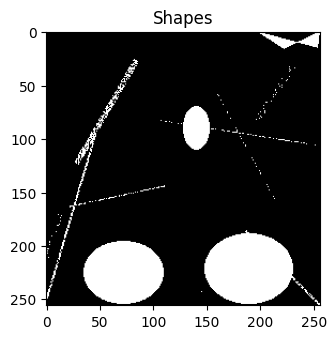

In [8]:
complete_solution(save_dir='predictions/', algorithm='KMeans', show_plots=True)

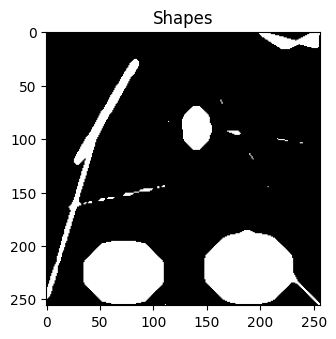

In [11]:
complete_solution(save_dir='predictions2/', algorithm='CA', show_plots=True)